# CMA-ES

In [1]:
import numpy as np
import cma
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from typing import Callable

### Optimization Problems

This cell defines three common benchmark functions, Sphere, Rosenbrock, and Rastrigin, used to test optimization algorithms. We also used these functions earlier to evaluate Adam and Momentum.

In [2]:
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x**2))


def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

### Helper functions

Convergence plot and animation.

In [3]:
def plot_convergence(histories: dict[str, list[float]]) -> None:
    plt.figure()
    for name, fitness in histories.items():
        plt.plot(fitness, label=name)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("CMA-ES Convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

def animate_distribution(
    func: Callable[[np.ndarray], float],
    mu_history: list[np.ndarray],
    cov_history: list[np.ndarray],
    bounds: tuple[float, float] = (-5, 5),
    frames: int = 50,
    filename: str = "cma_es_animation.mp4",
) -> None:
    x = np.linspace(bounds[0], bounds[1], 200)
    y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.array([func(pt) for pt in coords]).reshape(X.shape)

    fig, ax = plt.subplots()
    levels = np.logspace(np.log10(Z.min() + 1e-6), np.log10(Z.max()), 30)

    def update(frame_index: int) -> None:
        ax.clear()
        ax.contour(X, Y, Z, levels=levels, cmap="viridis")
        mu = mu_history[frame_index]
        cov = cov_history[frame_index]
        vals, vecs = np.linalg.eigh(cov)
        angle = float(np.degrees(np.arctan2(vecs[0, 1], vecs[0, 0])))
        width, height = 2 * np.sqrt(vals)
        ellipse = Ellipse(
            xy=mu,
            width=width,
            height=height,
            angle=angle,
            edgecolor="red",
            facecolor="none",
            lw=2,
        )
        ax.add_patch(ellipse)
        ax.plot(mu[0], mu[1], "ro")
        ax.set_title(f"Generation {frame_index}")
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

    anim = FuncAnimation(fig, update, frames=min(frames, len(mu_history)), interval=200)
    anim.save(filename, writer="ffmpeg")
    print(f"Animation saved to {filename}")

### Running CMA-ES

In [4]:
from dataclasses import dataclass

@dataclass
class CMAESResult:
    best_fitness: list[float]
    mean_history: list[np.ndarray]
    cov_history: list[np.ndarray]
    sigma_history: list[float]

def run_cma_es(
    func: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float,
    max_iterations: int = 100
) -> CMAESResult:
    #Initalization CMA strategy
    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma0)

    #history contener
    best_fitness = []
    mean_history = []
    cov_history = []
    sigma_history = []

    for _ in range(max_iterations):
        # generate candidate population 
        candidates = es.ask()

        # evaluate
        fitnesses = [func(np.array(x)) for x in candidates]

        # update strategy
        es.tell(candidates, fitnesses)

        # save history
        best_fitness.append(min(fitnesses))
        mean_history.append(np.copy(es.mean))
        cov_history.append(np.copy(es.sm.covariance_matrix))
        sigma_history.append(es.sigma)

        # stop condition
        if es.stop():
            break

    return CMAESResult(
        best_fitness=best_fitness,
        mean_history=mean_history,
        cov_history=cov_history,
        sigma_history=sigma_history
    )

### Ex. 1: Impact of (wpływ) the Starting Point
1.	Choose Rosenbrock in 2D.
2.	Run CMA-ES from at least five widely separated initial means (e.g., [-4,-4], [-1,3], [5,5]).
3.	Plot convergence curves and report:
- best fitness vs. generation,
- total evaluations to reach (całkowitą liczbe ewaluacji) $f(x)\lt10^{-8}$ (or termination).
4.	Briefly discuss (krótko omów) sensitivity to the start point. Prepare GIFs for two different starting points.

Hint: use `sigma0 = 0.5` and `max_iter = 250`.

Running CMA-ES from start point [-4 -4]
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=297835, Wed May 14 16:51:59 2025)
Running CMA-ES from start point [-2  2]
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=296041, Wed May 14 16:51:59 2025)
Running CMA-ES from start point [-1  3]
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=366945, Wed May 14 16:51:59 2025)
Running CMA-ES from start point [8 4]
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=364606, Wed May 14 16:51:59 2025)
Running CMA-ES from start point [5 5]
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=360493, Wed May 14 16:51:59 2025)


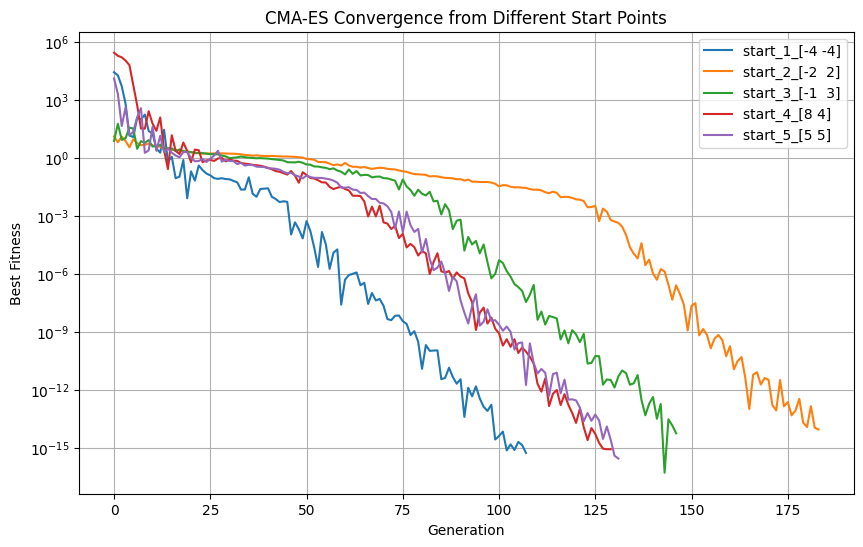

In [5]:
starting_points = [
    np.array([-4, -4]),
    np.array([-2, 2]),
    np.array([-1, 3]),
    np.array([8, 4]),
    np.array([5, 5])
]

sigma0 = 0.5
max_iter = 250

results = {}

for i, x0 in enumerate(starting_points):
    print(f"Running CMA-ES from start point {x0}")
    result = run_cma_es(func=rosenbrock, x0=x0, sigma0=sigma0, max_iterations=max_iter)
    results[f"start_{i+1}_{x0}"] = result.best_fitness

def plot_convergence(histories):
    plt.figure(figsize=(10, 6))
    for label, fitness in histories.items():
        plt.plot(fitness, label=label)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("CMA-ES Convergence from Different Start Points")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_convergence(results)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=317007, Wed May 14 16:07:49 2025)


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved to rosen_fixed.gif


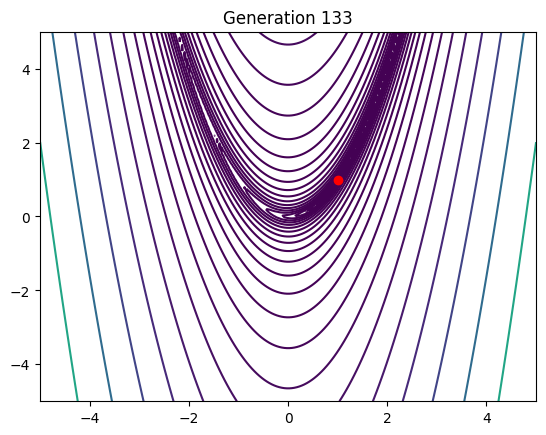

In [8]:
res = run_cma_es(
    func=rosenbrock,
    x0=np.array([4, -2]),  
    sigma0=0.5,
    max_iterations=250
)

animate_distribution(
    func=rosenbrock,
    mu_history=res.mean_history,
    cov_history=res.cov_history,
    bounds=(-5, 5),
    frames=250,
    filename="rosen_fixed.gif"
)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=263100, Wed May 14 16:11:05 2025)


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved to rosen_fixed_2.gif


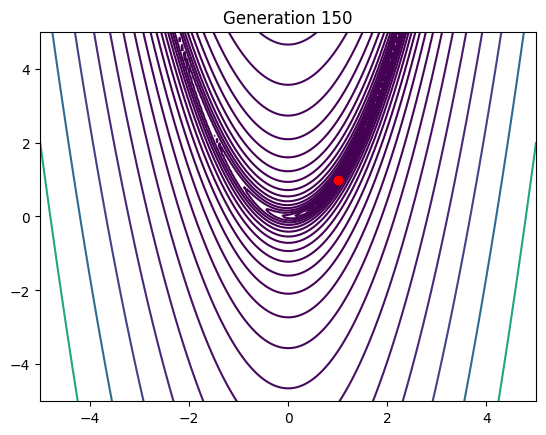

In [10]:
res = run_cma_es(
    func=rosenbrock,
    x0=np.array([-4, 4]),  
    sigma0=0.5,
    max_iterations=250
)

animate_distribution(
    func=rosenbrock,
    mu_history=res.mean_history,
    cov_history=res.cov_history,
    bounds=(-5, 5),
    frames=250,
    filename="rosen_fixed_2.gif"
)

Briefly discuss: If we start with two widely separated points, the CMA-ES algorithm is still able to find the minimum in both cases. However, the difference lies in the number of iterations: 150 vs. 133.

### Ex. 2: Effect of the Initial Global Step‐Size $\sigma_0$
1. Use [2,2] at starting point on the Rastrigin function.
2. Test $\sigma_0\in\{0.1,\,0.5,\,1,\,2,\,5\}$.
3. Record and plot
- final fitness after a fixed budget (e.g. 1000 evals)
- evolution of es.sigma over time (w czasie) (log scale).
4. Explain why too-small and too-large $\sigma_0$ hurt performance (pogarsza wydajność), relating findings to (odwołując się do) the adaptation rule.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=375874, Wed May 14 16:52:06 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=320299, Wed May 14 16:52:06 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=391769, Wed May 14 16:52:06 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=404128, Wed May 14 16:52:06 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=415748, Wed May 14 16:52:06 2025)


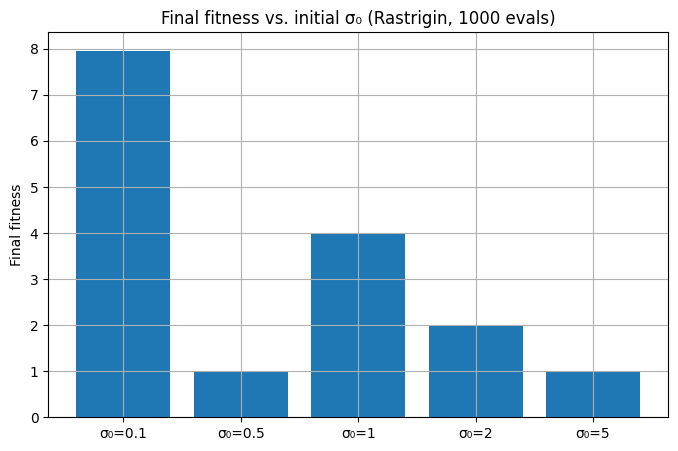

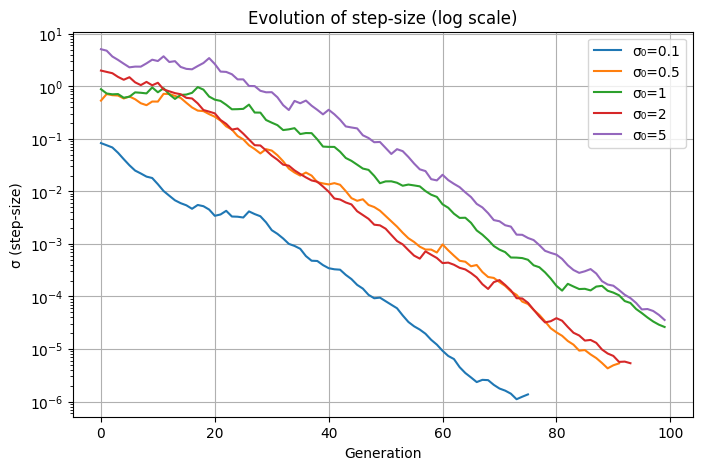

In [6]:
sigmas_to_test = [0.1, 0.5, 1, 2, 5]
starting_point = np.array([2.0, 2.0])
max_evals = 1000
results = {}



for sigma0 in sigmas_to_test:
    res = run_cma_es(
        func=rastrigin,
        x0=starting_point,
        sigma0=sigma0,
        max_iterations=max_evals // 10  
    )
    results[f"σ₀={sigma0}"] = res



#final fitness
plt.figure(figsize=(8, 5))
final_fitness = [res.best_fitness[-1] for res in results.values()]
plt.bar(results.keys(), final_fitness)
plt.ylabel("Final fitness")
plt.title("Final fitness vs. initial σ₀ (Rastrigin, 1000 evals)")
plt.grid(True)
plt.show()

# sigma evolution figure
plt.figure(figsize=(8, 5))
for label, res in results.items():
    plt.plot(res.sigma_history, label=label)
plt.yscale("log")
plt.xlabel("Generation")
plt.ylabel("σ (step-size)")
plt.title("Evolution of step-size (log scale)")
plt.legend()
plt.grid(True)
plt.show()


If we choose too small a value for $\sigma_0$, there's a high probability that the algorithm will get stuck in a local minimum.  
In the evolution of step-size figure, we can see that the step-size quickly decreases in the following generations, which limits  
the algorithm’s ability to explore the search space effectively. This happens because the adaptation rule in CMA-ES — specifically   
the cumulative step-size adaptation (CSA) — reduces $\sigma$ further when the evolutionary path is short, as it interprets this as lack of progress.  

On the other hand, if we choose too large a value for $\sigma_0$, the algorithm takes very large steps and jumps around the search  
space without adapting to the local structure of the function. In this case, the adaptation rule gets noisy or unclear signals about  
where to go, which can stop the step-size from changing in the right way. As a result, the algorithm may miss promising regions and  
fail to reach a good solution.

### Ex. 3: Visualising the Covariance Matrix Adaptation
1. On Sphere in 2D, log es.C (macierz kowariancji) every 5 generations.
2. Use the provided `animate_distribution` to produce a GIF showing the shrinking (lurczenie się) and rotation of the sampling ellipse.
3. Submit the animation and two short observations about what the animation reveals regarding (ujawnia w odniesieniu do) step-size vs. shape adaptation.

MovieWriter ffmpeg unavailable; using Pillow instead.


(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=364288, Wed May 14 17:39:04 2025)
Animation saved to sphere_covariance.gif


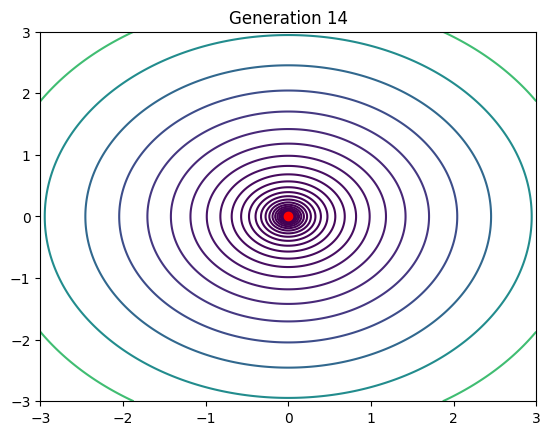

In [9]:
x0 = [2.0, 2.0]
sigma0 = 0.5
es = cma.CMAEvolutionStrategy(x0, sigma0)

mean_vectors = []
cov_matrices = []

while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [sphere(x) for x in solutions])

    if es.countiter % 5 == 0:
        mean_vectors.append(es.mean.copy())
        cov_matrices.append(es.C.copy())

animate_distribution(
    func=sphere,
    mu_history=mean_vectors,
    cov_history=cov_matrices,
    bounds=(-3, 3),
    frames=len(mean_vectors),
    filename="sphere_covariance.gif"
)

Obs_1: With each generation, the ellipse becomes smaller. This means the step-size is decreasing, and the algorithm is converging toward the minimum.  
Obs_2: The ellipse does not rotate significantly because the Sphere function is convex and symmetric, so no shape adaptation is needed.